In [85]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

# Matplotlib
import matplotlib.pyplot as plt

# OS
import os
import argparse
from tqdm.auto import tqdm

from typing import Dict, List, Optional, Tuple
from IPython.display import clear_output

In [67]:
IMAGE_DATASETS = ["cifar10"]
TITLE_FONT_SIZE = 16

def prepare_images(train_data: np.ndarray, test_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    train_data = train_data / 255.0
    train_data = np.transpose(train_data, (0, 3, 1, 2))

    if test_data is not None:
        test_data = test_data / 255.0
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        return train_data, test_data

    return train_data


def load_CIFAR10(
    with_test: bool = False, with_targets: bool = False
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    train_dataset = CIFAR10(root="./", train=True, download=True)
    train_data = train_dataset.data

    if with_test:
        test_dataset = CIFAR10(root="./", train=False, download=True)
        test_data = test_dataset.data
        test_labels = np.array(test_dataset.targets)
        return test_data, test_labels

    if with_targets:
        # train_labels, test_labels = (
        #     np.array(train_dataset.targets),
        #     np.array(test_dataset.targets),
        # )
        train_labels = np.array(train_dataset.targets)
        return train_data, train_labels

    return train_data


def load_dataset(
    name: str,
    with_targets: bool = False,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    train_data, train_labels, test_data, test_labels = load_CIFAR10(with_targets=with_targets)
    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if name in IMAGE_DATASETS:
        train_data, test_data = prepare_images(train_data, test_data)

    if classes is not None:
        train_mask = np.isin(train_labels, classes)
        test_mask = np.isin(test_labels, classes)

        train_data = train_data[train_mask]
        test_data = test_data[test_mask]

        if with_targets:
            train_labels = train_labels[train_mask]
            test_labels = test_labels[test_mask]

    if with_targets:
        return train_data, train_labels, test_data, test_labels

    return train_data, test_data

def show_samples(
    samples: np.ndarray | torch.Tensor,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [108]:
# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

def create_model():
    autoencoder = Autoencoder()
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder


def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.Flatten(),
            nn.Linear(768, 256),
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 768),
            nn.ReLU(),
            nn.Unflatten(1, torch.Size((48, 4, 4))),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def train(autoencoder, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, inputs in enumerate(train_loader, 0):
            inputs = get_torch_vars(inputs)

            # ============ Forward ============
            encoded, outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ============ Logging ============
            running_loss += loss.data
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    return autoencoder

In [ ]:
BATCH_SIZE = 16

train_data, test_data = load_dataset("cifar10")
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
epochs = 50

autoencoder = create_model()
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters())

model = train(autoencoder, train_loader, test_loader, criterion, optimizer, epochs)

Model moved to GPU in order to speed up training.
[1,  2000] loss: 0.618
[2,  2000] loss: 0.592
[3,  2000] loss: 0.585
[4,  2000] loss: 0.582
[5,  2000] loss: 0.579
[6,  2000] loss: 0.577
[7,  2000] loss: 0.575
[8,  2000] loss: 0.573
[9,  2000] loss: 0.572
[10,  2000] loss: 0.572
[11,  2000] loss: 0.571
[12,  2000] loss: 0.570
[13,  2000] loss: 0.569
[14,  2000] loss: 0.568
[15,  2000] loss: 0.568
[16,  2000] loss: 0.567
[17,  2000] loss: 0.567
[18,  2000] loss: 0.566
[19,  2000] loss: 0.567
[20,  2000] loss: 0.566
[21,  2000] loss: 0.566
[22,  2000] loss: 0.565
[23,  2000] loss: 0.564
[24,  2000] loss: 0.565
[25,  2000] loss: 0.564
[26,  2000] loss: 0.564
[27,  2000] loss: 0.564
[28,  2000] loss: 0.564
[29,  2000] loss: 0.564
[30,  2000] loss: 0.563
[31,  2000] loss: 0.563
[32,  2000] loss: 0.563
[33,  2000] loss: 0.563
[34,  2000] loss: 0.563
[35,  2000] loss: 0.563
[36,  2000] loss: 0.562
[37,  2000] loss: 0.562
[38,  2000] loss: 0.562
[39,  2000] loss: 0.562
[40,  2000] loss: 0.562

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


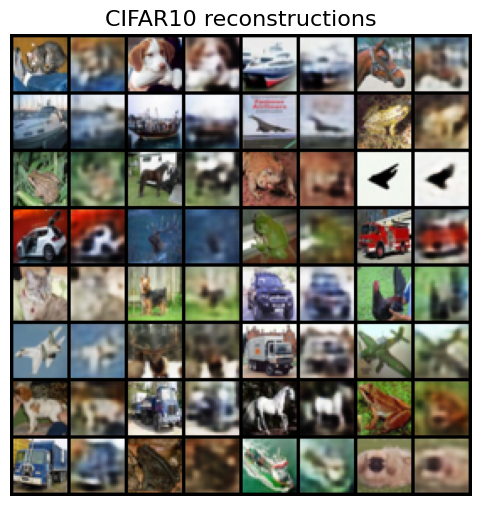

In [ ]:
data_iter = iter(test_loader)
x = next(data_iter)
y = next(data_iter)
x = torch.stack((x, y), dim=1).view(-1, 3, 32, 32)

x = x.to(DEVICE)

with torch.no_grad():
    # z, _ = model.encoder(x)
    # x_recon = torch.clamp(model.decoder(z), -1, 1)
     _, new_fig = model(x)
reconstructions = torch.stack((x, new_fig), dim=1).view(-1, 3, 32, 32)
reconstructions = reconstructions.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')

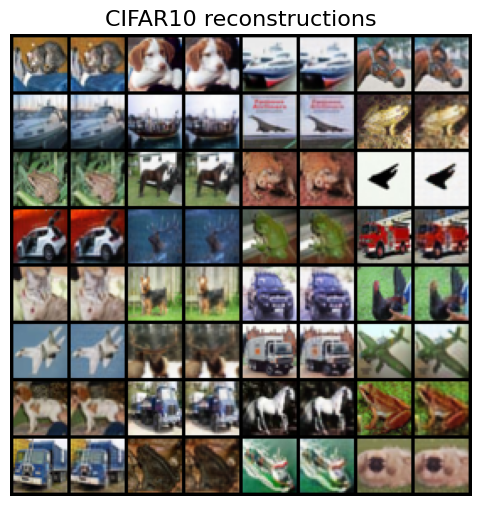

In [ ]:
data_iter = iter(test_loader)
x = next(data_iter)
y = next(data_iter)
x = torch.stack((x, y), dim=1).view(-1, 3, 32, 32)

x = x.to(DEVICE)

with torch.no_grad():
    # z, _ = model.encoder(x)
    # x_recon = torch.clamp(model.decoder(z), -1, 1)
     _, new_fig = model(x)
reconstructions = torch.stack((x, new_fig), dim=1).view(-1, 3, 32, 32)
reconstructions = reconstructions.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')

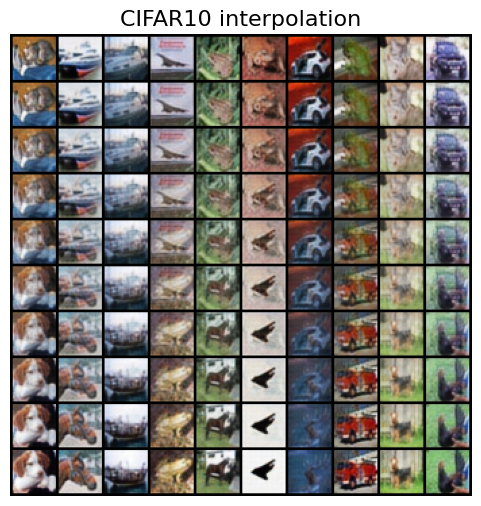

In [ ]:
data_iter = iter(test_loader)
x = next(data_iter)[:10]
y = next(data_iter)[:10]

with torch.no_grad():
    latent_space1 = autoencoder.encoder(x.to(DEVICE))
    latent_space2 = autoencoder.encoder(y.to(DEVICE))

interp_steps = 10
weight = torch.linspace(0, 1, steps=interp_steps)
interp = torch.lerp(
    latent_space1.repeat(interp_steps, 1, 1, 1, 1),
    latent_space2.repeat(interp_steps, 1, 1, 1, 1),
    weight=weight.view(-1, 1, 1, 1, 1).to(DEVICE),
)
with torch.no_grad():
    iterp_imgs = autoencoder.decoder(interp.view(-1, 48, 4, 4))
interps = iterp_imgs.view(-1, 3, 32, 32)
interps = torch.clamp(interps, -1, 1).cpu().numpy()

show_samples(interps, 'CIFAR10 interpolation')

# Дополнительные функции

In [73]:
def load_dataset(
    name: str,
    with_test: bool = False,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    train_data, train_labels = load_CIFAR10(with_test=with_test, with_targets=True)
    train_data = train_data.astype("float32")

    train_data = prepare_images(train_data)

    if classes is not None:
        train_mask = np.isin(train_labels, classes)
        train_data = train_data[train_mask]

    return train_data

In [94]:
import random

def random_vector_generator():
    while True:
        a = random.uniform(0, 1)
        b = random.uniform(0, 1)
        c = random.uniform(0, 1)
        abc_sum = a + b + c
        yield {5: a / abc_sum, 6: b / abc_sum, 8: c / abc_sum}

In [107]:
generator = random_vector_generator()
next(generator)

{5: 0.38768915957372024, 6: 0.27472272264174097, 8: 0.3375881177845388}

In [75]:
def sample_data(data: np.ndarray, proportion: float) -> np.ndarray:
    num_elements = int(proportion * data.shape[0])
    random_indices = np.random.choice(data.shape[0], num_elements, replace=False)
    return data[random_indices]

def get_data(classes_proportions: Dict[int, float]) -> Tuple[np.ndarray, np.ndarray]:
    props_sum = sum(classes_proportions.values())
    if (1 - 1e-7 <= props_sum <= 1 + 1e-7) != 1:
        raise ValueError("Сумма долей классов должна быть равна 1")

    train_lst = []
    test_lst = []
    for class_ind, proportion in classes_proportions.items():
        train_class_data = load_dataset("cifar10", classes = [class_ind])
        train_lst.append(sample_data(train_class_data, proportion))
        # test_lst.append(sample_data(test_class_data, proportion))

    train_data = np.concatenate(train_lst).reshape((-1, 3, 32, 32))
    # test_data = np.concatenate(test_lst).reshape((-1, 3, 32, 32))

    return train_data

# MSE, таргет -- доли классов в датасете

In [87]:
def train_model(train_loader, epochs):
    autoencoder = create_model()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, inputs in enumerate(train_loader, 0):
            inputs = get_torch_vars(inputs)

            # ============ Forward ============
            encoded, outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ============ Logging ============
            # running_loss += loss.data
            # if i % 2000 == 1999:
            #     tqdm.write(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")
            #     running_loss = 0.0
    return autoencoder

In [88]:
def get_vector(model, test_loader):
    model.eval()
    all_encoded_outputs = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            encoded_output, _ = model(batch.to("cuda"))
            all_encoded_outputs.append(encoded_output)

    all_encoded_outputs = torch.cat(all_encoded_outputs, dim=0)
    mean_encoded_output = torch.mean(all_encoded_outputs, dim=0)
    return mean_encoded_output

In [71]:
test_data, test_labels = load_CIFAR10(with_test=True)
test_data = test_data.astype("float32")
test_data = prepare_images(test_data)
test_mask = np.isin(test_labels, [5, 6, 8])
test_data = test_data[test_mask]

Files already downloaded and verified
Files already downloaded and verified


In [116]:
num_models = 30
num_epochs = 30
BATCH_SIZE = 32

generator = random_vector_generator()
vectors_test = []
datasets_test = []

test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

for i in tqdm(range(num_models)):
    classes_proportions = next(generator)
    train_data = get_data(classes_proportions)
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    model = train_model(train_loader, num_epochs)
    vector = get_vector(model, test_loader)
    vectors_test.append(vector)
    datasets_test.append(classes_proportions)

  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model moved to GPU in order to speed up training.


  0%|          | 0/30 [00:00<?, ?it/s]

In [135]:
def train_encoder(model, train_loader, epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        count = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            outputs = model(inputs.to("cuda"))
            loss = criterion(outputs, labels.to("cuda"))
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ============ Logging ============
            running_loss += loss.data
            count += 1
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / count:.4f}")
        running_loss = 0.0
        count = 0
    return model

In [169]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        # x = self.sigmoid(x)
        return x

In [126]:
data_list = []

for dataset in datasets:
    data_list.append(torch.Tensor(list(dataset.values())))

data_list_test = []

for dataset in datasets_test:
    data_list_test.append(torch.Tensor(list(dataset.values())))

In [128]:
train_tensor = torch.stack(vectors)
train_labels = torch.stack(data_list)

test_tensor = torch.stack(vectors_test)
test_labels = torch.stack(data_list_test)

In [213]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_tensor, train_labels)
test_dataset = TensorDataset(test_tensor, test_labels)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [219]:
epochs = 10

encoder = Encoder(256, 64, 3).to("cuda")
encoder = train_encoder(encoder, train_loader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.0438
Epoch 2/10, Loss: 0.0199
Epoch 3/10, Loss: 0.0071
Epoch 4/10, Loss: 0.0029
Epoch 5/10, Loss: 0.0025
Epoch 6/10, Loss: 0.0028
Epoch 7/10, Loss: 0.0028
Epoch 8/10, Loss: 0.0025
Epoch 9/10, Loss: 0.0022
Epoch 10/10, Loss: 0.0019


In [220]:
encoder.eval()
outputs = []
labels = []

with torch.no_grad():
    for i, (batch, label) in enumerate(test_loader):
        output = encoder(batch.to("cuda"))
        outputs.append(output)
        labels.append(label)

outputs = torch.cat(outputs, dim=0)
labels = torch.cat(labels, dim=0)

In [221]:
outputs = outputs.cpu()

In [222]:
((outputs - labels) ** 2).mean()

tensor(0.0477)

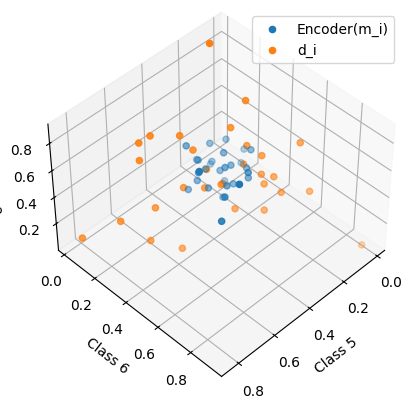

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Создание фигуры и осей для 3D графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Построение точек
ax.scatter(outputs[:, 0], outputs[:, 1], outputs[:, 2], label="Encoder(m_i)")
ax.scatter(labels[:, 0], labels[:, 1], labels[:, 2], label="d_i")

# Настройка меток осей
ax.set_xlabel('Class 5')
ax.set_ylabel('Class 6')
ax.set_zlabel('Class 8')

ax.view_init(elev=45, azim=45)

# Отображение графика
plt.legend()
plt.show()

kmeans

3 картинки класса

Веса

Расстояния между двумя точками на сфере

# Две модели. Таргет -- расстояние между выходами

# Contrastive learning

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, samples, labels):
        dist_matrix = torch.cdist(samples, labels, p=2)

        batch_size = samples.size(0)
        pos_mask = torch.eye(batch_size, dtype=torch.bool, device=samples.device)
        neg_mask = ~pos_mask

        pos_dist = dist_matrix[pos_mask]
        neg_dist = dist_matrix[neg_mask]
        loss = torch.sum(torch.relu(self.margin + pos_dist - neg_dist))

        return loss

class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, samples, labels):
        dist_matrix = torch.cdist(samples, labels, p=2)

        batch_size = samples.size(0)
        pos_mask = torch.eye(batch_size, dtype=torch.bool, device=samples.device)
        neg_mask = ~pos_mask

        pos_sim = torch.exp(-dist_matrix[pos_mask] / self.temperature)
        neg_sim = torch.exp(-dist_matrix[neg_mask] / self.temperature)
        total_sim = pos_sim + neg_sim.sum()

        loss = -torch.log(pos_sim / total_sim)
        return loss

In [ ]:
input_dim = 128  # Размерность скрытого пространства автоэнкодера (flatten)
hidden_dim = 64
output_dim = 32

encoder_a = Encoder(input_dim, hidden_dim, output_dim)
contrastive_loss = ContrastiveLoss()
optimizer = optim.Adam(encoder_a.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    features = encoder_a(hidden_representations)
    loss = contrastive_loss(features, labels)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')